In [ ]:
%pip install split-folders

In [ ]:
%pip install opencv-contrib-python-headless

In [3]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os 
import shutil
import boto3, sagemaker
from sagemaker import get_execution_role
import cv2

In [4]:
# Define role, region, session, and s3 resource 
role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()
s3 = boto3.resource("s3")

In [5]:
print(f'role: {role}, region: {region}, sess: {sess}')

role: arn:aws:iam::654654364700:role/SageMaker-Developer, region: us-east-1, sess: <sagemaker.session.Session object at 0x7f5983781a80>


**EDA: Imbalance**
-

In [ ]:
# Copy data locally into JL in terminal with following command
# aws s3 sync s3://grass-carp-ploidy/input/ ./images/diploid

In [56]:
# count images in each class (double checking class imbalance between magnification)
# find . -type d -name '.ipynb_checkpoints' -exec rm -r {} +

count_good = len(os.listdir('training_images/diploid'))
print(f"How many of each Diploid: {count_good}")
print(" ")

count_triploid_good = len(os.listdir('training_images/triploid'))
print(f"How many of each Triploid: {count_triploid_good}")


How many of each Diploid: 242
 
How many of each Triploid: 258


**I don't see too much class imbalance at all, so accuracy metric will not be affected.**

In [12]:
# function to get dimensions of images
def get_dims(im):
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w 

**Dimensions**
-

Text(0.5, 0, 'Triploid_field')

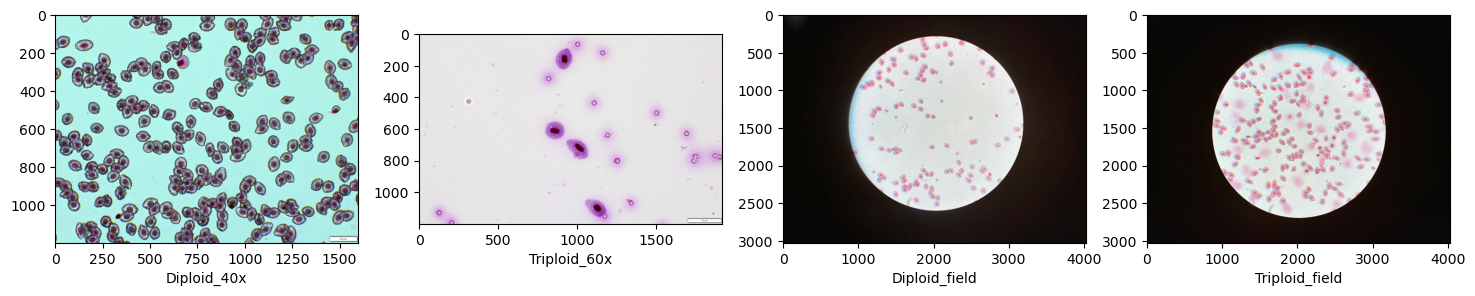

In [16]:
# viewing images ORIGINAL SIZE
dip_40 = cv2.imread('training_images/diploid/2N_GC3_1_S1a_40X.tif')
trip_60 = cv2.imread('training_images/triploid/3N_GC1_1_S2c_60X.tif')
field = cv2.imread('2N_GC1_5d_60X_field.jpg')
field2 = cv2.imread('3N_GC3_2E_60X_field.jpg')
# plot the images
fig, ax = plt.subplots(1,4, figsize = (18,18))
ax[0].imshow(dip_40)
ax[0].set_xlabel("Diploid_40x")
ax[1].imshow(trip_60)
ax[1].set_xlabel("Triploid_60x")
ax[2].imshow(field)
ax[2].set_xlabel("Diploid_field")
ax[3].imshow(field2)
ax[3].set_xlabel("Triploid_field")

In [17]:
print(f' dimension of dip_40: {get_dims(dip_40)}')
print(f' dimension of trip_60: {get_dims(trip_60)}')
print(f' dimension of diploid field: {get_dims(field)}')
print(f' dimension of triploid field: {get_dims(field2)}')

 dimension of dip_40: (1200, 1600)
 dimension of trip_60: (1200, 1920)
 dimension of diploid field: (3024, 4032)
 dimension of triploid field: (3024, 4032)


**Dimensions of 40x and 60x are the same but the images of the field are much to big, will need to resize.**

**Diploid Cropping**
--

In [9]:
def center_crop(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converts this BGR image to greyscale
    thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1] # threshold image
    x, y, w, h = cv2.boundingRect(thresh) # get bounding box around nonzeros
    #print(f'x: {x}, y: {y},h: {h}, w: {w}')

    #cutting off corners that are black 
    y_end = int(y + h)
    x_end = int(x +w)
    quart_w = w // 6
    quart_h = h // 6

    cropped_img = image[y + quart_h :y_end - quart_h, x + quart_w: x_end - quart_w]

    return cropped_img

In [21]:
#crop all images in the field folder 
# input_folder = 'images/diploid/Good!'
# output_folder = 'images/diploid/resized_field'

# for file in os.listdir(input_folder):
#     path = os.path.join(input_folder, file)
#     img = cv2.imread(path)

#     cropped = center_crop(img)

#     #resized_image = cv2.resize(cropped, (640, 640))
#     cv2.imwrite(os.path.join(output_folder, file), cropped)

In [10]:
print(f"How many of each cropped diploid: {len(os.listdir('images/diploid/resized_field'))}")

How many of each cropped diploid: 42


In [ ]:
# view all cropped images
one = cv2.imread("images/diploid/Good!/2N_GC1_10c_60X_field.jpg")
two = cv2.imread("images/diploid/Good!/2N_GC1_4d_60X_field.jpg")
three = cv2.imread("images/diploid/Good!/PRETTY2N_GC1_10_60X_field.jpg")

one = center_crop(one)
two = center_crop(two)
three = center_crop(three)

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(one)
ax[1].imshow(two)
ax[2].imshow(three)

**Triploid Cropping**
--


In [ ]:
# viewing images ORGINAL SIZE
trip_40 = cv2.imread('images/triploid/40X/3N_GC1_10_S1b_40X.tif')
trip_60 = cv2.imread('images/triploid/60X/3N_GC1_2_S3a_60X.tif')
trip_field = cv2.imread('images/triploid/Good!/3N_GC3_2G_60X_field.jpg')

# plot the images
fig, ax = plt.subplots(1,3, figsize = (10,10))
ax[0].imshow(trip_40)
ax[0].set_xlabel("Triploid_40x")
ax[1].imshow(trip_60)
ax[1].set_xlabel("Triploid_60x")
ax[2].imshow(trip_field)
ax[2].set_xlabel("Triploid_field")

In [22]:
#crop all images in the field folder 
# input_folder = 'images/triploid/Good!'
# output_folder = 'images/triploid/resized_field'

# for file in os.listdir(input_folder):
#     path = os.path.join(input_folder, file)
#     img = cv2.imread(path)

#     cropped = center_crop(img)

#     #resized_image = cv2.resize(cropped, (640, 640))
#     cv2.imwrite(os.path.join(output_folder, file), cropped)

In [13]:
print(f"How many of each cropped triploid: {len(os.listdir('images/triploid/resized_field'))}")

How many of each cropped triploid: 28


In [ ]:
# view all cropped images
one = cv2.imread("images/triploid/resized_field/3N_GC3_2D_60X_field.jpg")
two = cv2.imread("images/triploid/resized_field/3N_GC3_2F_60X_field.jpg")
three = cv2.imread("images/triploid/resized_field/GOOD3N_GC3_3_60X_field.jpg")
#one2 = cv2.resize(one, (640,640))

fig, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(one)
ax[1].imshow(two)
ax[2].imshow(three)

**Move images to new folder/check for duplicates**
--
                

In [ ]:
#To copy over files from one folder to the one i'll use to train

# mv images/diploid/40X/* training_images/diploid/
# mv images/diploid/60X/* training_images/diploid/
# mv images/diploid/resized_field/* training_images/diploid/

# mv images/triploid/40X/* training_images/triploid/
# mv images/triploid/60X/* training_images/triploid/
# mv images/triploid/resized_field/* training_images/triploid/

print(f"How many of each cropped diploid: {len(os.listdir('training_images/triploid'))}")

In [5]:
#checkin for duplicate files in my training_image directory
import os
from collections import Counter

# Specify the directory to check
dip_directory = 'training_images/diploid'  
trip_directory = 'training_images/triploid'

file_names_dip = []
file_names_trip = []

# Traverse the directory
for root, dirs, files in os.walk(dip_directory):
    for file in files:
        file_names_dip.append(file)
        
# Traverse the directory
for root, dirs, files in os.walk(trip_directory):
    for file in files:
        file_names_trip.append(file)

# Count occurrences of each file name
duplicates_dip = [item for item, count in Counter(file_names_dip).items() if count > 1]
duplicates_trip = [item for item, count in Counter(file_names_trip).items() if count > 1]

# Print duplicate file names
if duplicates_dip or duplicates_trip:
    print("Duplicate file names found:")
    for name in duplicates_dip:
        print(name)
    for name in duplicates_trip:
        print(name)
else:
    print("No duplicate file names found.")

No duplicate file names found.


/home/sagemaker-user


Text(0.5, 0, 'Triploid_60x')

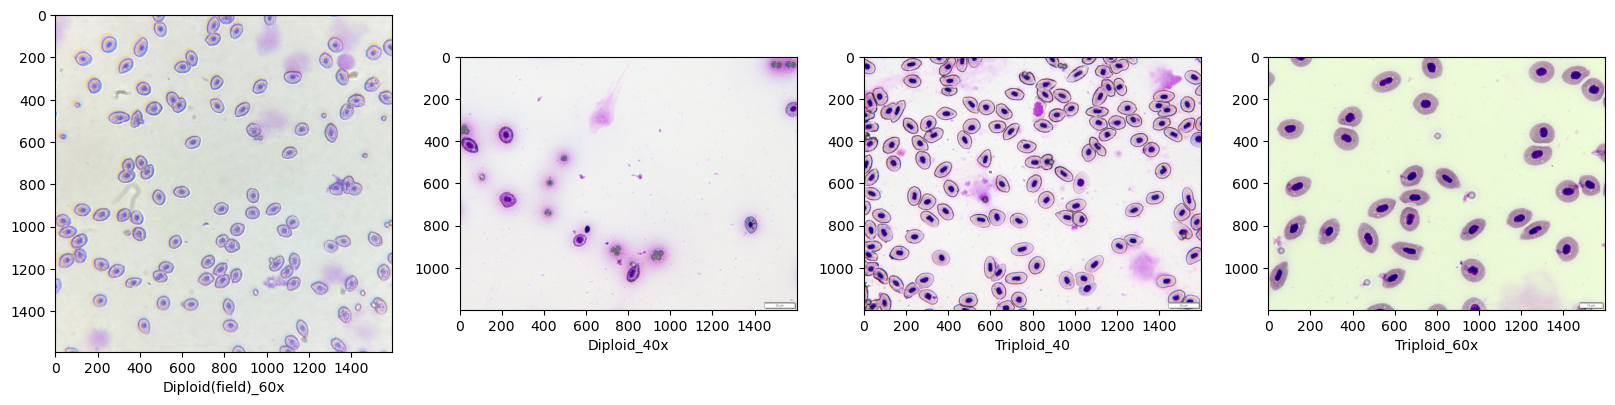

In [19]:
# viewing images ORGINAL SIZE
%cd
one = Image.open('training_images/diploid/2N_GC1_3d_60X_field.jpg')
two = Image.open('training_images/diploid/2N_GC1_Slide2_image2_40X.tif')
three = Image.open('training_images/triploid/3N_GC1_10_S1c_40X.tif')
four = Image.open('training_images/triploid/3N_GC1_5_S1b_60X.tif')

# plot the images
fig, ax = plt.subplots(1,4, figsize = (20,20))
ax[0].imshow(one)
ax[0].set_xlabel("Diploid(field)_60x")
ax[1].imshow(two)
ax[1].set_xlabel("Diploid_40x")
ax[2].imshow(three)
ax[2].set_xlabel("Triploid_40")
ax[3].imshow(four)
ax[3].set_xlabel("Triploid_60x")

In [20]:
print(f'Pixel range: {np.min(one), np.max(one)}')
print(f'Pixel range: {np.min(four), np.max(four)}')

Pixel range: (46, 255)
Pixel range: (0, 255)


**Resizing/Changing to jpg then splitting**
-

In [ ]:
def change_images(input_folder, output_folder, new_size=(640, 640)):

    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

        # Check if the file is a .tif or .tiff image
        if filename.lower().endswith(('.tif')):
                tiff_img = Image.open(image_path)
                if tiff_img is not None:
                    # resize and change color
                    tiff_img = tiff_img.resize(new_size)
                    jpg_img = tiff_img.convert("RGB")

                    # split filename and add jpg extension 
                    new_filename = os.path.splitext(filename)[0] + '.jpg'
                    new_image_path = os.path.join(output_folder, new_filename)

                    # save new jpg and delete old tiff
                    jpg_img.save(new_image_path, 'JPEG')
                else:
                    print("Image that won't load: ", image_path)
        else:
            image = Image.open(image_path)
            #resize and change color
            resized = image.resize(new_size)
            colored = resized.convert("RGB")
            
            #create new filepath and save jpg
            new_filename = os.path.splitext(filename)[0] + '.jpg'
            new_image_path = os.path.join(output_folder, new_filename)
            colored.save(new_image_path, 'JPEG')

print("Resizing complete.")

In [59]:
# input_folder = 'training_images/diploid'
output_folder = 'processed_images/triploid'
input_folder = "training_images/triploid"

change_images(input_folder, output_folder)

In [61]:
#checking all images made it over
print(len(os.listdir('training_images/diploid')))
print(len(os.listdir('processed_images/diploid')))
print(len(os.listdir('training_images/triploid')))
print(len(os.listdir('processed_images/triploid')))

242
242
258
258


Text(0.5, 0, 'Triploid')

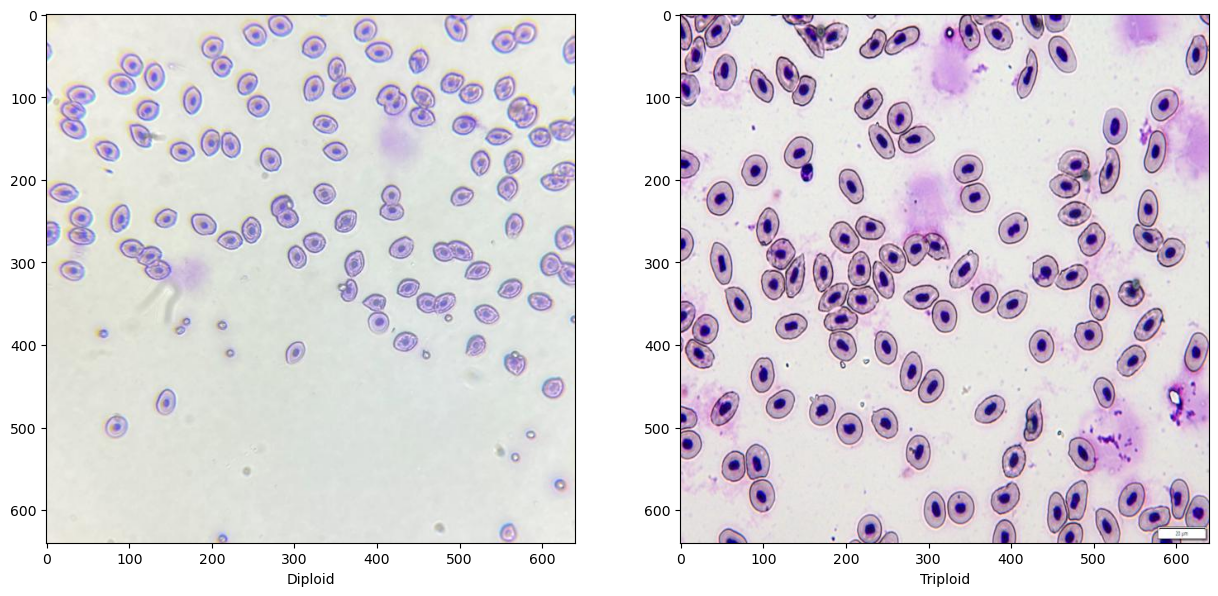

In [67]:
one = Image.open("processed_images/diploid/2N_GC1_3e_60X_field.jpg")
two = Image.open("processed_images/triploid/3N_GC1_10_S1a_40X.jpg")

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(one)
ax[0].set_xlabel("Diploid")
ax[1].imshow(two)
ax[1].set_xlabel("Triploid")

**Now split folders (70,15,15)**
-

In [62]:
import splitfolders
splitfolders.ratio("processed_images", seed = 13, ratio=(.7, .15, .15))

Copying files: 500 files [00:00, 1255.77 files/s]


In [63]:
train_trip = int(len(os.listdir('output/train/triploid')))
train_dip = int(len(os.listdir('output/train/diploid')))

val_trip = len(os.listdir('output/val/triploid'))
val_dip = len(os.listdir('output/val/diploid'))

test_trip = len(os.listdir('output/test/triploid'))
test_dip = len(os.listdir('output/test/diploid'))

print(f"How many train triploid/diploid: {train_trip + train_dip}, and {train_trip} triploid and {train_dip} diploid")
print(f"How many val triploid/diploid: {val_trip + val_dip} and {val_trip} triploid and {val_dip} diploid")
print(f"How many test triploid/diploid: {test_trip + test_dip} and {test_trip} triploid and {test_dip} diploid")

How many train triploid/diploid: 349, and 180 triploid and 169 diploid
How many val triploid/diploid: 74 and 38 triploid and 36 diploid
How many test triploid/diploid: 77 and 40 triploid and 37 diploid
